# Health and PCA

This notebook is based on our Antibiotic PCA notebook but considers the other markers of health, too!

In [1]:
import os
import sys
from socket import gethostname

# this is for ffmpeg
os.environ['PATH'] += os.pathsep + os.path.expanduser('~/miniconda3/envs/bioinformatics/bin')

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

In [2]:
encoder_models = 'cluster_gbrfs'
# encoder_models = 'cluster_gbrfs_all'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['Cluster', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['Cluster'] = cluster_assignments['Cluster'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)


In [3]:
intcols = ['Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
pca = PCA(n_components=1)
md = metadata[intcols].dropna(subset=intcols)
md['Antibiotics_YN_enc'] = md['Antibiotics_YN'].astype('category').cat.codes
antibiotic_cols = ['Antibiotics_YN_enc', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
scaled = StandardScaler().fit_transform(md[antibiotic_cols])
tmp = pca.fit_transform(scaled)
md['Medications Score'] = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * 100

In [4]:
intcols = ['IP vs OP', 'FEV1/best FEV1', 'Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']

intcol = intcols[1]
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[intcols]).dropna(subset=intcol).join(md[['Medications Score']])

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]

# cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score.tsv.gz'), compression='gzip', sep="\t", index_col=0)
cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score_tokenised.tsv.gz'), compression='gzip', sep="\t", index_col=0)
cluster_virulence

,Tokens,Virulence Factors,Intersection,Union,Jaccard Distance,Normalised Jaccard,Frac cluster virulence,Enrichment Score,Normalized Enrichment Score
Cluster,,,,,,,,,
Cluster 1,8,3600,1,3607,0.000277,0.037448,0.125000,-0.823333,-0.699717
Cluster 2,12,3600,1,3611,0.000277,0.037406,0.083333,-0.882222,-0.789264
Cluster 3,7,3600,0,3607,0.000000,0.000000,0.000000,-1.000000,-1.000000
Cluster 4,14,3600,3,3611,0.000831,0.112219,0.214286,-0.697143,-0.535088
Cluster 5,16,3600,7,3609,0.001940,0.261989,0.437500,-0.381667,-0.235839
...,...,...,...,...,...,...,...,...,...
Cluster 146,58,3600,5,3653,0.001369,0.184881,0.086207,-0.878161,-0.782787
Cluster 147,37,3600,8,3629,0.002204,0.297766,0.216216,-0.694414,-0.531880
Cluster 148,12,3600,1,3611,0.000277,0.037406,0.083333,-0.882222,-0.789264


# The 3D version

I've made this (hopefully) standalone so we can make a separate movie for each interesting column

In [5]:
intcols = ['IP vs OP', 'Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs', 'FEV1/best FEV1']

#intcol = intcols[7]
intcol = 'Medications Score'
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[intcols]).dropna(subset=intcols).join(md[['Medications Score']])

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(merged_df, intcol, merged_df)

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]


le = LabelEncoder()
if intcol == 'FEV1/best FEV1':
    cols = y
else:
    cols = le.fit_transform(y)

# 3D PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

# Prepare loadings and enrichment
loading_weight_X = round(max(pca_result[:, 0]), -5) 
loading_weight_Y = round(max(pca_result[:, 1]), -5) 
loading_weight_Z = round(max(pca_result[:, 2]), -5) 
loadings = pca.components_.T  # shape: (n_features, 3)
scaling_factor = 5000
x_load, y_load, z_load = loadings[:, 0]*loading_weight_X, loadings[:, 1]*loading_weight_Y, loadings[:, 2]*loading_weight_Z

topN = 6
loading_magnitude = np.sum(loadings**2, axis=1)
top_indices = np.argsort(loading_magnitude)[-topN:]  # Top 5 variables

# define the color palettes
cpalette = 'coolwarm'
meshpalette = 'BrBG_r'

# Get enrichment scores for each variable
es = 'Normalised Jaccard' # 'Enrichment Score', 'Jaccard Distance', 'Frac cluster virulence', 'Normalised Jaccard', 'Normalised Enrichment Score',
enrichment_scores = [cluster_virulence.loc[col, es] if col in cluster_virulence.index else 0 for col in X.columns]
flare_cmap = ListedColormap(sns.color_palette(cpalette, as_cmap=True)(np.linspace(0, 1, 256))) 
colors = flare_cmap((np.array(enrichment_scores) + 1) / 2)

# 3. RBF interpolation
points = np.column_stack((x_load, y_load, z_load))
values = np.array(enrichment_scores)
rbf = RBFInterpolator(points, values, kernel='thin_plate_spline')

# 4. 3D Grid
x_range = np.linspace(min(pca_result[:,0])-2, max(pca_result[:,0])+2, 40)
y_range = np.linspace(min(pca_result[:,1])-2, max(pca_result[:,1])+2, 40)
z_range = np.linspace(min(pca_result[:,2])-2, max(pca_result[:,2])+2, 40)

xx, yy, zz = np.meshgrid(x_range, y_range, z_range)
grid_points = np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))
grid_vals = rbf(grid_points)
grid_vals = np.clip(grid_vals, min(enrichment_scores), max(enrichment_scores))


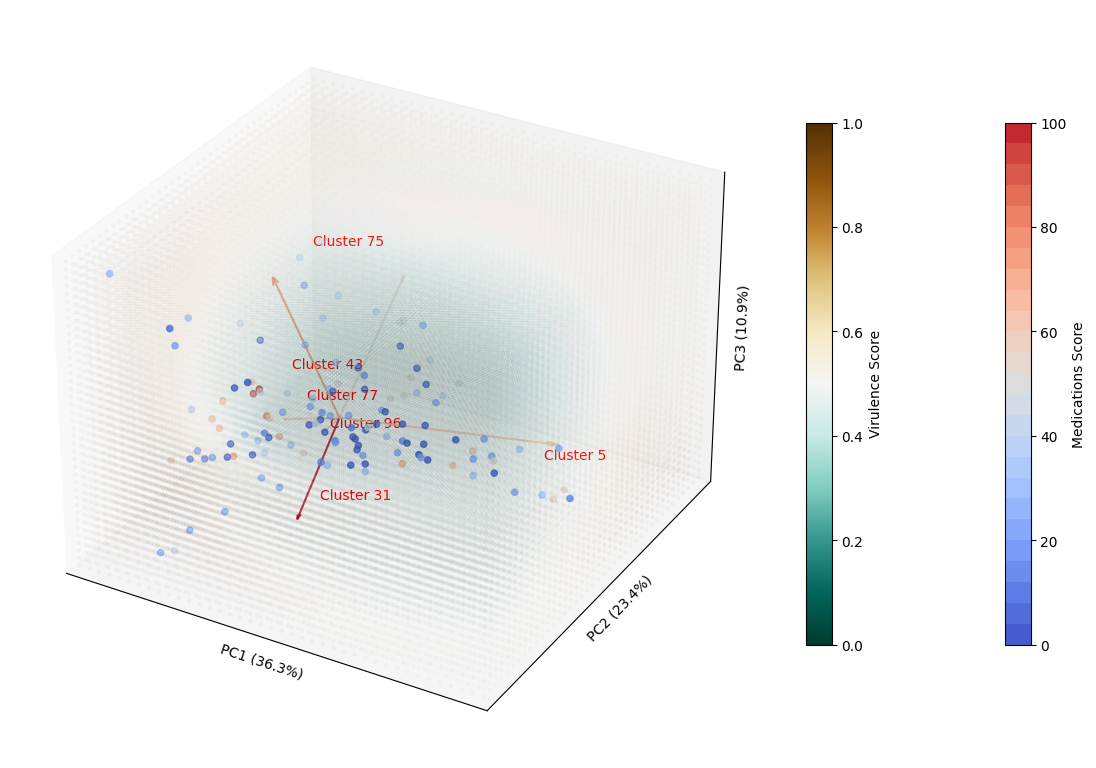

In [6]:
# for the figure in the paper we remove some of the decorations like title that end up in the legend
for_figure = True

# 5. Plot enrichment as colored scatter mesh
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')


# Enrichment mesh
sc_mesh = ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], 
                     c=grid_vals, cmap=meshpalette, alpha=0.025, s=5)

# Sample points
#sc_samples = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
#                        c=y, cmap=mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique()))))
if categorical_data:
    mycmap = cpalette
else:
    mycmap = mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique())))
sc_samples = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                        c=y, cmap=mycmap)


# Loadings arrows
for i in top_indices:
    ax.quiver(0, 0, 0, 
              x_load[i], y_load[i], z_load[i], 
              color=colors[i], alpha=0.8, arrow_length_ratio=0.05)
    ax.text(x_load[i], y_load[1], z_load[i], X.columns[i], color='r', fontsize=10)

# Axes labels
ax.xaxis.labelpad = -10  # default ~10, so reduce to move closer
ax.yaxis.labelpad = -10
ax.zaxis.labelpad = -10
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
if not for_figure:
    ax.set_title(f'3D PCA with {es} Mesh Overlay colored by {intcol_title}')

# adjust the ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlim(min(pca_result[:,0])-2, max(pca_result[:,0])+2)
ax.set_ylim(min(pca_result[:,1])-2, max(pca_result[:,1])+2)
ax.set_zlim(min(pca_result[:,2])-2, max(pca_result[:,2])+2)

# Colorbar

if categorical_data:
    handles = []
    for val in sorted(y.unique()):
        label = custom_labels[val]
        color = sc_samples.cmap(sc_samples.norm(val))
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label,
                                  markerfacecolor=color, markersize=8))
    ax.legend(handles=handles, title=intcol_title)
else:
    cb2 = fig.colorbar(sc_samples, label=intcol_title, shrink=0.6, aspect=20)

#cb = fig.colorbar(sc_mesh, shrink=0.6, aspect=20)
sm = ScalarMappable(cmap=meshpalette, norm=sc_mesh.norm)
sm.set_array([])
cb = fig.colorbar(sm, ax=sc_mesh.axes, shrink=0.6, aspect=20)

if for_figure:
    cb.set_label("Virulence Score")
else:
    cb.set_label(es)
plt.grid(False)
plt.tight_layout()
plt.show()

# Lets make lots of animations

In [7]:
# Rotate function
def rotate(angle):
    ax.view_init(elev=30, azim=angle)

In [8]:
intcols = ['IP vs OP', 'FEV1/best FEV1', 'Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']

merged_df = pc_df.join(metadata[intcols]).dropna(subset=intcols).join(md[['Medications Score']])

intcols += ['Medications Score']
testcol = ['Medications Score']
os.makedirs("anime", exist_ok=True)
for intcol in intcols:
    #for intcol in testcol:
    intcol_title = replace_index.sub('', intcol).replace('_', ' ')
    intcol_filename = replace_index.sub('', intcol).replace('/', '').replace(' ', '_').replace('(', '').replace(')', '')
    
    categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)
    
    X = merged_df.drop(intcols, axis=1)
    y = merged_df[intcol]
    
    
    le = LabelEncoder()
    if intcol == 'FEV1/best FEV1' or intcol == 'Medications Score':
        cols = y
    else:
        cols = le.fit_transform(y)
    
    # 3D PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(X)
    
    # Prepare loadings and enrichment
    loading_weight_X = round(max(pca_result[:, 0]), -5) 
    loading_weight_Y = round(max(pca_result[:, 1]), -5) 
    loading_weight_Z = round(max(pca_result[:, 2]), -5) 
    loadings = pca.components_.T  # shape: (n_features, 3)
    scaling_factor = 5000
    x_load, y_load, z_load = loadings[:, 0]*loading_weight_X, loadings[:, 1]*loading_weight_Y, loadings[:, 2]*loading_weight_Z
    
    topN = 6
    loading_magnitude = np.sum(loadings**2, axis=1)
    top_indices = np.argsort(loading_magnitude)[-topN:]  # Top 5 variables
    
    
    # Get enrichment scores for each variable
    es = 'Normalised Jaccard' # 'Enrichment Score', 'Jaccard Distance', 'Frac cluster virulence'
    #es_label = 'Normalised Jaccard index J(cluster terms, VFDB)'
    es_label = 'Virulence Score'
    enrichment_scores = [cluster_virulence.loc[col, es] if col in cluster_virulence.index else 0 for col in X.columns]
    
    #flare_cmap = ListedColormap(sns.color_palette(cpalette, as_cmap=True)(np.linspace(0, 1, 256))) 
    #colors = flare_cmap((np.array(enrichment_scores) + 1) / 2)
    colors = plt.cm.coolwarm((np.array(enrichment_scores) + 1) / 2)  # Normalize -1 to 1
    
    # 3. RBF interpolation
    points = np.column_stack((x_load, y_load, z_load))
    values = np.array(enrichment_scores)
    rbf = RBFInterpolator(points, values, kernel='thin_plate_spline')
    
    # 4. 3D Grid
    x_range = np.linspace(min(pca_result[:,0])-2, max(pca_result[:,0])+2, 40)
    y_range = np.linspace(min(pca_result[:,1])-2, max(pca_result[:,1])+2, 40)
    z_range = np.linspace(min(pca_result[:,2])-2, max(pca_result[:,2])+2, 40)
    
    xx, yy, zz = np.meshgrid(x_range, y_range, z_range)
    grid_points = np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))
    grid_vals = rbf(grid_points)
    grid_vals = np.clip(grid_vals, min(enrichment_scores), max(enrichment_scores))


    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Enrichment mesh
    sc_mesh = ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], 
                         c=grid_vals, cmap=meshpalette, alpha=0.025, s=5)

    if categorical_data:
        mycmap = cpalette
    else:
        mycmap = mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique())))
    sc_samples = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                            c=y, cmap=mycmap)
    
    
    # Loadings arrows
    for i in top_indices:
        ax.quiver(0, 0, 0, 
                  x_load[i], y_load[i], z_load[i], 
                  color='r', alpha=0.8, arrow_length_ratio=0.05)
        ax.text(x_load[i], y_load[1], z_load[i], X.columns[i], color='r', fontsize=10)
    
    # Axes labels
    ax.xaxis.labelpad = -10  # default ~10, so reduce to move closer
    ax.yaxis.labelpad = -10
    ax.zaxis.labelpad = -10
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
    ax.set_title(f'{intcol_title}')
    
    # adjust the ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.set_xlim(min(pca_result[:,0])-2, max(pca_result[:,0])+2)
    ax.set_ylim(min(pca_result[:,1])-2, max(pca_result[:,1])+2)
    ax.set_zlim(min(pca_result[:,2])-2, max(pca_result[:,2])+2)
    
    
    # Colorbar    
    # cb = fig.colorbar(sc_mesh, shrink=0.6, aspect=20)
    sm = ScalarMappable(cmap=meshpalette, norm=sc_mesh.norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=sc_mesh.axes, shrink=0.6, aspect=20)
    cb.set_label(es_label)
    
    if categorical_data:
        handles = []
        for val in sorted(y.unique()):
            label = custom_labels[val]
            color = sc_samples.cmap(sc_samples.norm(val))
            handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label,
                                      markerfacecolor=color, markersize=8))
        ax.legend(handles=handles, title=intcol_title, loc='upper right')
    else:
        #cb2 = fig.colorbar(sc_samples, label=intcol_title, shrink=0.6, aspect=20)
        pass

    plt.grid(False)
    plt.tight_layout()
    # Create animation
    rot_animation = animation.FuncAnimation(fig, rotate, frames=range(0, 360, 2), interval=50)
    
    # Save as mp4 (requires ffmpeg) or gif
    rot_animation.save(f"anime/{intcol_filename}.mp4", dpi=200, bitrate=1800)
    plt.close()


# Concatentate all the movies using ffmpeg!

This uses a simple `ffmpeg` command to make a single movie

In [9]:
healthmp4 = os.path.join('anime', 'health.mp4')
if os.path.exists(os.path.join(healthmp4)):
    os.remove(healthmp4)
    
with open('movie_files.txt', 'w') as out:
    print("""
file 'anime/Medications_Score.mp4'
file 'anime/Antibiotics_YN.mp4'
file 'anime/IP_vs_OP.mp4'
file 'anime/Sum_of_antibiotics.mp4'
file 'anime/Sum_of_antifungals.mp4'
file 'anime/Sum_of_meds.mp4'
file 'anime/Sum_of_steroid_+_mabs.mp4'
""", file=out)
! ffmpeg -f concat -safe 0 -i movie_files.txt -c copy anime/health.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.4.0 (conda-forge gcc 10.4.0-18)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

# Two color movies

These variables only have two choices (y/n) so we only need two colors

In [10]:
oricols = ['IP vs OP', 'Antibiotics_YN', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
merged_df = pc_df.join(metadata[oricols]).dropna(subset=oricols)

merged_df['Antifungals_YN'] = merged_df['Sum of antifungals'].apply(lambda x: 'No' if x == 0 else 'Yes').astype('category')
merged_df['Meds_YN'] = merged_df['Sum of meds'].apply(lambda x: 'No' if x == 0 else 'Yes').astype('category')
merged_df['Steroids_YN'] = merged_df['Sum of steroid + mabs'].apply(lambda x: 'No' if x == 0 else 'Yes').astype('category')

intcols = ['Antifungals_YN', 'Meds_YN', 'Steroids_YN', 'IP vs OP', 'Antibiotics_YN']
merged_df = merged_df.dropna(subset=intcols)

anime_dir = 'anime_yn'
os.makedirs(anime_dir, exist_ok=True)
cpalette = 'PuBu'
cmap = plt.get_cmap(cpalette)
colors = [cmap(0.2), cmap(0.8)]  # light and dark
color_map = {'No': colors[0], 'Yes': colors[1], 'IP': colors[0], 'OP': colors[1]}
custom_labels = {0: 'No', 1: 'Yes', 'No' : 0, 'Yes' : 1, 'IP': 'IP', 'OP': 'OP'}
for intcol in intcols:
    print(intcol, file=sys.stderr)
    intcol_title = replace_index.sub('', intcol).replace('_', ' ')
    intcol_filename = replace_index.sub('', intcol).replace('/', '').replace(' ', '_')
    
    X = merged_df.drop(intcols, axis=1)
    y = merged_df[intcol]
    
    # 3D PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(X)
    
    # Prepare loadings and enrichment
    loading_weight_X = round(max(pca_result[:, 0]), -5) 
    loading_weight_Y = round(max(pca_result[:, 1]), -5) 
    loading_weight_Z = round(max(pca_result[:, 2]), -5) 
    loadings = pca.components_.T  # shape: (n_features, 3)
    scaling_factor = 5000
    x_load, y_load, z_load = loadings[:, 0]*loading_weight_X, loadings[:, 1]*loading_weight_Y, loadings[:, 2]*loading_weight_Z
    
    topN = 6
    loading_magnitude = np.sum(loadings**2, axis=1)
    top_indices = np.argsort(loading_magnitude)[-topN:]  # Top 5 variables
    
    
    # Get enrichment scores for each variable
    es = 'Normalised Jaccard' # 'Enrichment Score', 'Jaccard Distance', 'Frac cluster virulence'
    es_label = 'Normalised Jaccard index J(cluster terms, VFDB)'
    enrichment_scores = [cluster_virulence.loc[col, es] if col in cluster_virulence.index else 0 for col in X.columns]
    #flare_cmap = ListedColormap(sns.color_palette("coolwarm", as_cmap=True)(np.linspace(0, 1, 256))) 
    #colors = flare_cmap((np.array(enrichment_scores) + 1) / 2)
    
    # 3. RBF interpolation
    points = np.column_stack((x_load, y_load, z_load))
    values = np.array(enrichment_scores)
    rbf = RBFInterpolator(points, values, kernel='thin_plate_spline')
    
    # 4. 3D Grid
    x_range = np.linspace(min(pca_result[:,0])-2, max(pca_result[:,0])+2, 40)
    y_range = np.linspace(min(pca_result[:,1])-2, max(pca_result[:,1])+2, 40)
    z_range = np.linspace(min(pca_result[:,2])-2, max(pca_result[:,2])+2, 40)
    
    xx, yy, zz = np.meshgrid(x_range, y_range, z_range)
    grid_points = np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))
    grid_vals = rbf(grid_points)
    grid_vals = np.clip(grid_vals, min(enrichment_scores), max(enrichment_scores))

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Enrichment mesh
    sc_mesh = ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], 
                         c=grid_vals, cmap=cpalette, alpha=0.025, s=5)

    point_colors = merged_df[intcol].astype(str).map(color_map)
    sc_samples = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                            c=point_colors)
    
    
    # Loadings arrows
    for i in top_indices:
        ax.quiver(0, 0, 0, 
                  x_load[i], y_load[i], z_load[i], 
                  color='r', alpha=0.8, arrow_length_ratio=0.05)
        ax.text(x_load[i], y_load[1], z_load[i], X.columns[i], color='r', fontsize=10)
    
    # Axes labels
    ax.xaxis.labelpad = -10  # default ~10, so reduce to move closer
    ax.yaxis.labelpad = -10
    ax.zaxis.labelpad = -10
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
    ax.set_title(f'{intcol_title}')
    
    # adjust the ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.set_xlim(min(pca_result[:,0])-2, max(pca_result[:,0])+2)
    ax.set_ylim(min(pca_result[:,1])-2, max(pca_result[:,1])+2)
    ax.set_zlim(min(pca_result[:,2])-2, max(pca_result[:,2])+2)
    
    
    # Colorbar    
    cb = fig.colorbar(sc_mesh, shrink=0.6, aspect=20)
    cb.set_label(es_label)
    
    if categorical_data:
        handles = []
        for val in sorted(y.unique()):
            handles.append(plt.Line2D([0], [0], marker='o', color='w', label=val,
                                      markerfacecolor=color_map[val], markersize=8))
        ax.legend(handles=handles, title=intcol_title, loc='upper right')
    else:
        cb2 = fig.colorbar(sc_samples, label=intcol_title, shrink=0.6, aspect=20)

    plt.grid(False)
    plt.tight_layout()
    # Create animation
    rot_animation = animation.FuncAnimation(fig, rotate, frames=range(0, 360, 2), interval=50)
    
    # Save as mp4 (requires ffmpeg) or gif
    rot_animation.save(f"{anime_dir}/{intcol_filename}.mp4", dpi=200, bitrate=1800)
    plt.close()



Antifungals_YN
Meds_YN
Steroids_YN
IP vs OP
Antibiotics_YN


In [11]:
os.listdir('anime_yn')

['IP_vs_OP.mp4',
 'Antibiotics_YN.mp4',
 'Antifungals_YN.mp4',
 'Meds_YN.mp4',
 'Steroids_YN.mp4',
 'health_yn.mp4']

In [12]:
healthmp4 = os.path.join(anime_dir, 'health_yn.mp4')
if os.path.exists(os.path.join(healthmp4)):
    os.remove(healthmp4)
    
with open('movie_files_yn.txt', 'w') as out:
    print("""
file 'anime_yn/IP_vs_OP.mp4'
file 'anime_yn/Antibiotics_YN.mp4'
file 'anime_yn/Antifungals_YN.mp4'
file 'anime_yn/Meds_YN.mp4'
file 'anime_yn/Steroids_YN.mp4'
""", file=out)
! ffmpeg -f concat -safe 0 -i movie_files_yn.txt -c copy anime_yn/health_yn.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.4.0 (conda-forge gcc 10.4.0-18)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1666310205098/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

In [13]:
metadata.columns

Index(['minion', 'MGI', 'pwCF_ID', 'Sample date', 'IP vs OP', 'Hospital',
       'Room', 'Age', 'Age groups', 'Paediatric vs Adult',
       ...
       'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs',
       'DNA_extraction_ conc', 'SAGC ULN', 'DNA Conc. (ng/ul)', 'Index I7',
       'Index I5', 'Mean_Size_BP', 'Total Clusters Passing Filter (Million)'],
      dtype='object', length=166)